In [1]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import glob, re, os
from analysis_utils import load_checkpoints, rerun_trials
from architecture import ModelRNNv2, ModelWrapper
import matplotlib as mpl
from sklearn.decomposition import PCA
from tqdm import tqdm

In [2]:
H = 100
gs = np.linspace(0., 3., 2000)

def eval_model_ode_mode(g, ts = 100, dt = .1, h = None, model_dict = None):
    model = ModelWrapper(ModelRNNv2(n_hidden = H))
    if model_dict is not None:
        model.load_state_dict(model_dict)
    with torch.no_grad():
        model.rnn.W.weight.data *= g
        model.rnn.W_in.weight.data *= g
        model.rnn.W_out.weight.data *= g
        
    if h is None:
        h = torch.normal(torch.zeros(H), 1.)
    hidden = [h]
    for i in range(ts):
        h = (1-dt)*h + dt*model(h)[1]
        hidden.append(h.detach().numpy())
    return hidden

sweep_hidden = []
for g in gs:
    hidden = eval_model_ode_mode(g, ts = 300, dt = 0.1 / 3.)
    sweep_hidden.append(np.stack(hidden))

sweep_hidden = np.stack(sweep_hidden)
mean, var = np.mean(sweep_hidden, -1), np.var(sweep_hidden, -1)

edge_chaos = var > 0.1
edge_chaos = np.argmax(edge_chaos, axis = 0)

plt.figure(figsize = (5, 4))
# plt.subplot(1,2,1)
# plt.imshow(np.abs(mean), aspect='auto', origin='lower', cmap='seismic', norm=mpl.colors.LogNorm(vmin = 0.001), extent = [0, var.shape[1], gs[0], gs[-1]])
# plt.title('Mean')
plt.xlabel('Time, t')
plt.ylabel('Scale, g')
# plt.colorbar()
# plt.subplot(1,2,2)
plt.imshow(var, aspect='auto', origin='lower', cmap='seismic', norm=mpl.colors.LogNorm(vmin = 0.001), extent = [0, var.shape[1], gs[0], gs[-1]])
plt.title('Variance, $\Sigma(Z_{t,0})$', fontsize=15)
plt.xlabel('Time, $t$', fontsize=15)
plt.ylabel('Scale, $g$', fontsize=15)
# plt.plot(np.arange(var.shape[1])+.5, edge_chaos / var.shape[0] * gs[-1])
# plt.legend(['Edge of Chaos'])
plt.colorbar()
plt.show()

plt.plot(sweep_hidden[0, :, :5])
plt.show()

plt.plot(sweep_hidden[-1, :, :5])
plt.show()

KeyboardInterrupt: 

100%|██████████| 50/50 [00:06<00:00,  7.31it/s]


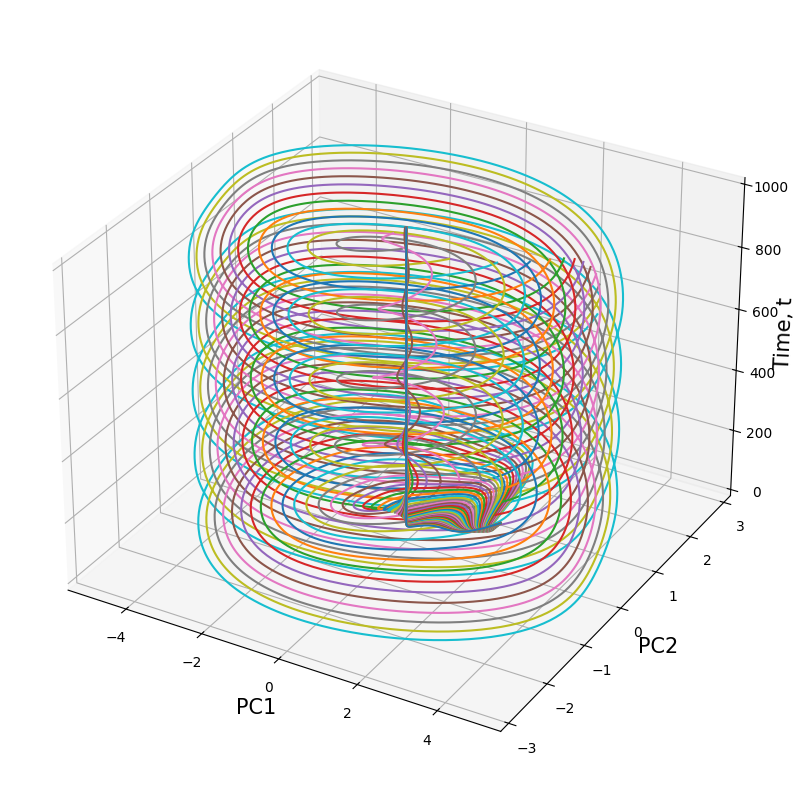

In [249]:

gs = [1.0, 1.5, 1.8, 1.9]
gs = np.linspace(1.0, 2., 50)
# gs = [1.8, 1.81]
torch.random.manual_seed(1)
model_dict = ModelWrapper(ModelRNNv2(n_hidden = H)).state_dict()
cat = []
h0 = torch.normal(torch.zeros(H), 1.)
for idx, g in enumerate(tqdm(gs)):
    activity = eval_model_ode_mode(g, ts = 1000, dt = .3, h=h0, model_dict = model_dict)
    cat.append(activity)

cat = np.stack(cat)
proj = PCA(3).fit_transform(cat.reshape((-1, cat.shape[-1]))).reshape((*cat.shape[:-1],3))
max_x = np.max(np.abs(proj[:, :, 0]))
max_y = np.max(np.abs(proj[:, :, 1]))
plt.figure(figsize = (10, 8))
ax = plt.axes(projection='3d')
cmap = plt.get_cmap('seismic')
for i in range(proj.shape[0]):
    ax.plot(proj[i, :, 0], proj[i, :, 1], np.arange(proj.shape[1]), zorder=proj.shape[0]-i)
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
ax.set_zlabel('Time, t', fontsize=15)
ax.zaxis.labelpad=-0.2 # <- change the value here
plt.xlim(-max_x, max_x)
plt.ylim(-max_y, max_y)
plt.tight_layout()
# plt.xscale('symlog')
# plt.yscale('symlog')
# plt.legend(gs)
plt.show()

In [ ]:

sweep_hidden = []
for g in gs:
    model = ModelWrapper(ModelRNNv2(n_hidden = H))
    with torch.no_grad():
        model.rnn.W.weight.data *= g
        model.rnn.W_in.weight.data *= g
        model.rnn.W_out.weight.data *= g
        
    h = torch.normal(torch.zeros(H), 1.)
    hidden = []
    for i in range(25):
        _, h = model(h)
        hidden.append(h.detach().numpy())
    sweep_hidden.append(np.stack(hidden))

sweep_hidden = np.stack(sweep_hidden)
mean, var = np.mean(sweep_hidden, -1), np.var(sweep_hidden, -1)

edge_chaos = var > 0.1
edge_chaos = np.argmax(edge_chaos, axis = 0)

plt.figure(figsize = (10, 3))
plt.subplot(1,2,1)
plt.imshow(np.abs(mean), aspect='auto', origin='lower', cmap='seismic', norm=mpl.colors.LogNorm(vmin = 0.001), extent = [0, var.shape[1], gs[0], gs[-1]])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(var, aspect='auto', origin='lower', cmap='seismic', norm=mpl.colors.LogNorm(vmin = 0.001), extent = [0, var.shape[1], gs[0], gs[-1]])
plt.plot(np.arange(var.shape[1])+1, edge_chaos / var.shape[0] * gs[-1])
plt.colorbar()
plt.show()

In [5]:
import memory_pro, category_pro, d1fp2_correlated_x, d1fp2
task = memory_pro
task_str = 'memory_pro'

def smooth(y, box_pts, mode = 'same'):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode=mode)
    return y_smooth


def get_best_acc(root, acc_thresh):
    name = load_checkpoints(root)[0][-1] # Final checkpoint
    ch = torch.load(name, weights_only=True)
    accs = smooth(ch['accuracies'], 50) # Smooth to get a min over multiple iterations.
    max_inds = np.argwhere(accs > acc_thresh)
    if len(max_inds) > 0:
        return max_inds[0], accs[max_inds[0]]
    max_idx = np.argmax(accs) # Threshold not hit, just take best accuracy. 
    return accs[max_idx], max_idx

In [ ]:
# Load the manifest for navigating the sweep.
with open('final_code/sweep/grid_manifest.json', 'r') as fin:
    manifest = json.load(fin)

# Filter manifest and sort.
manifest = list(filter(lambda params: params['task'] == task_str, manifest))
acc_thresh = manifest[0]['stopping_acc']
manifest.sort(key = lambda params: params['init_scale_percent'])
scales = [params['init_scale_percent'] for params in manifest]

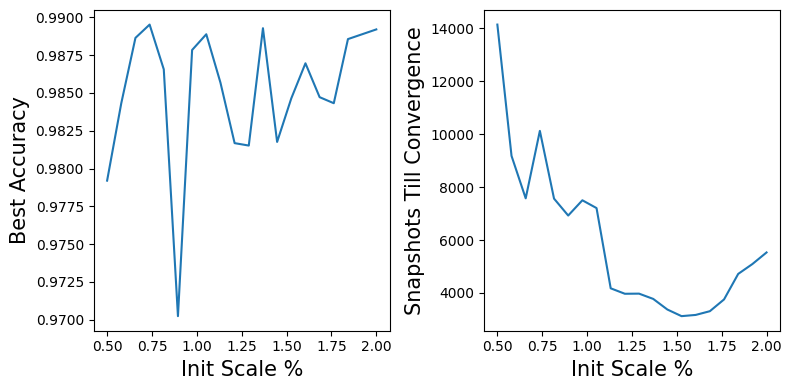

In [ ]:
accs = [get_best_acc('final_code/' + params['prefix'], acc_thresh) for params in manifest]
accs, best_itrs = [pair[0] for pair in accs], [pair[1] for pair in accs]

plt.figure(figsize = (8, 4))
plt.subplot(1,2,1)
plt.plot(scales, accs)
plt.xlabel('Init Scale %', fontsize = 15)
plt.ylabel('Best Accuracy', fontsize = 15)

plt.subplot(1,2,2)
plt.plot(scales, best_itrs)
plt.xlabel('Init Scale %', fontsize = 15)
plt.ylabel('Snapshots Till Convergence', fontsize = 15)
plt.tight_layout()
plt.show()

U(-percent/sqrt(n), percent/sqrt(n)). TODO: Check g in literature

In [59]:
checkpoints_best = ['final_code/' + params['prefix'] + 'best.pt' for params in manifest]
X, Y, z_trials, losses_trials = rerun_trials(task, checkpoints_best, noise = False, N = 100)

20


NameError: name 'saojdia' is not defined

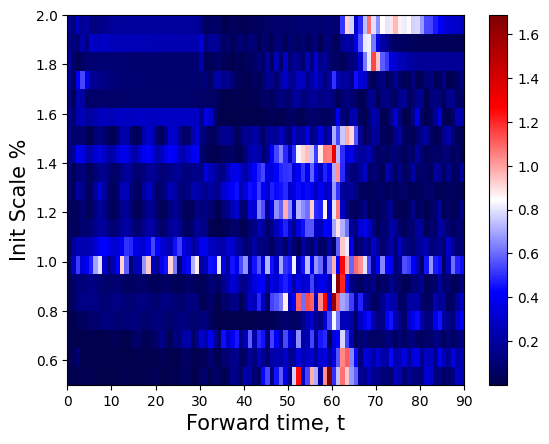

In [18]:
means = np.mean(np.linalg.norm(z_trials, axis = -1), axis = 1)
vars = np.var(np.linalg.norm(z_trials, axis = -1), axis = 1)

# for i in range(vars.shape[0]):
#     plt.plot(vars[i, :], c = [i / vars.shape[0], 0., 0.])

plt.figure()
plt.imshow(vars, aspect = 'auto', cmap = 'seismic', origin = 'lower', extent = [0, vars.shape[1], scales[0], scales[-1]])
plt.ylabel('Init Scale %', fontsize = 15)
plt.xlabel('Forward time, t', fontsize = 15)
plt.colorbar()
plt.show()

Re-evaluating on the Same Data.


final_code/sweep/grid_0/checkpoints/checkpoint_0.pt:   0%|          | 0/617 [00:00<?, ?it/s]

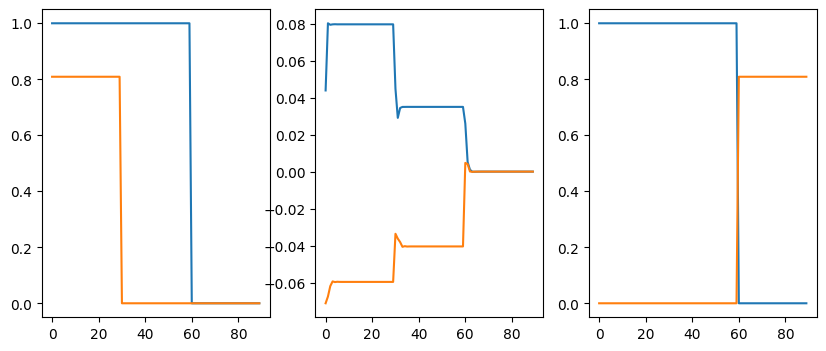

final_code/sweep/grid_38/checkpoints/checkpoint_5600.pt: 100%|█████████▉| 614/617 [00:18<00:00, 30.64it/s]

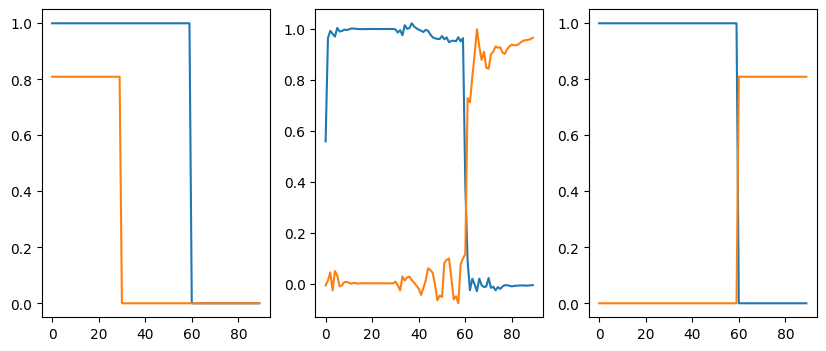

final_code/sweep/grid_38/checkpoints/checkpoint_5600.pt: 100%|██████████| 617/617 [00:18<00:00, 33.53it/s]


In [19]:
checkpoints_gd = [load_checkpoints('final_code/' + params['prefix'])[0] for params in manifest]
split_inds = np.cumsum([0] + [len(checkpoints) for checkpoints in checkpoints_gd])
checkpoints_gd = sum(checkpoints_gd, []) # Concatenate lists
z_over_gd = rerun_trials(task, checkpoints_gd, N = 50)

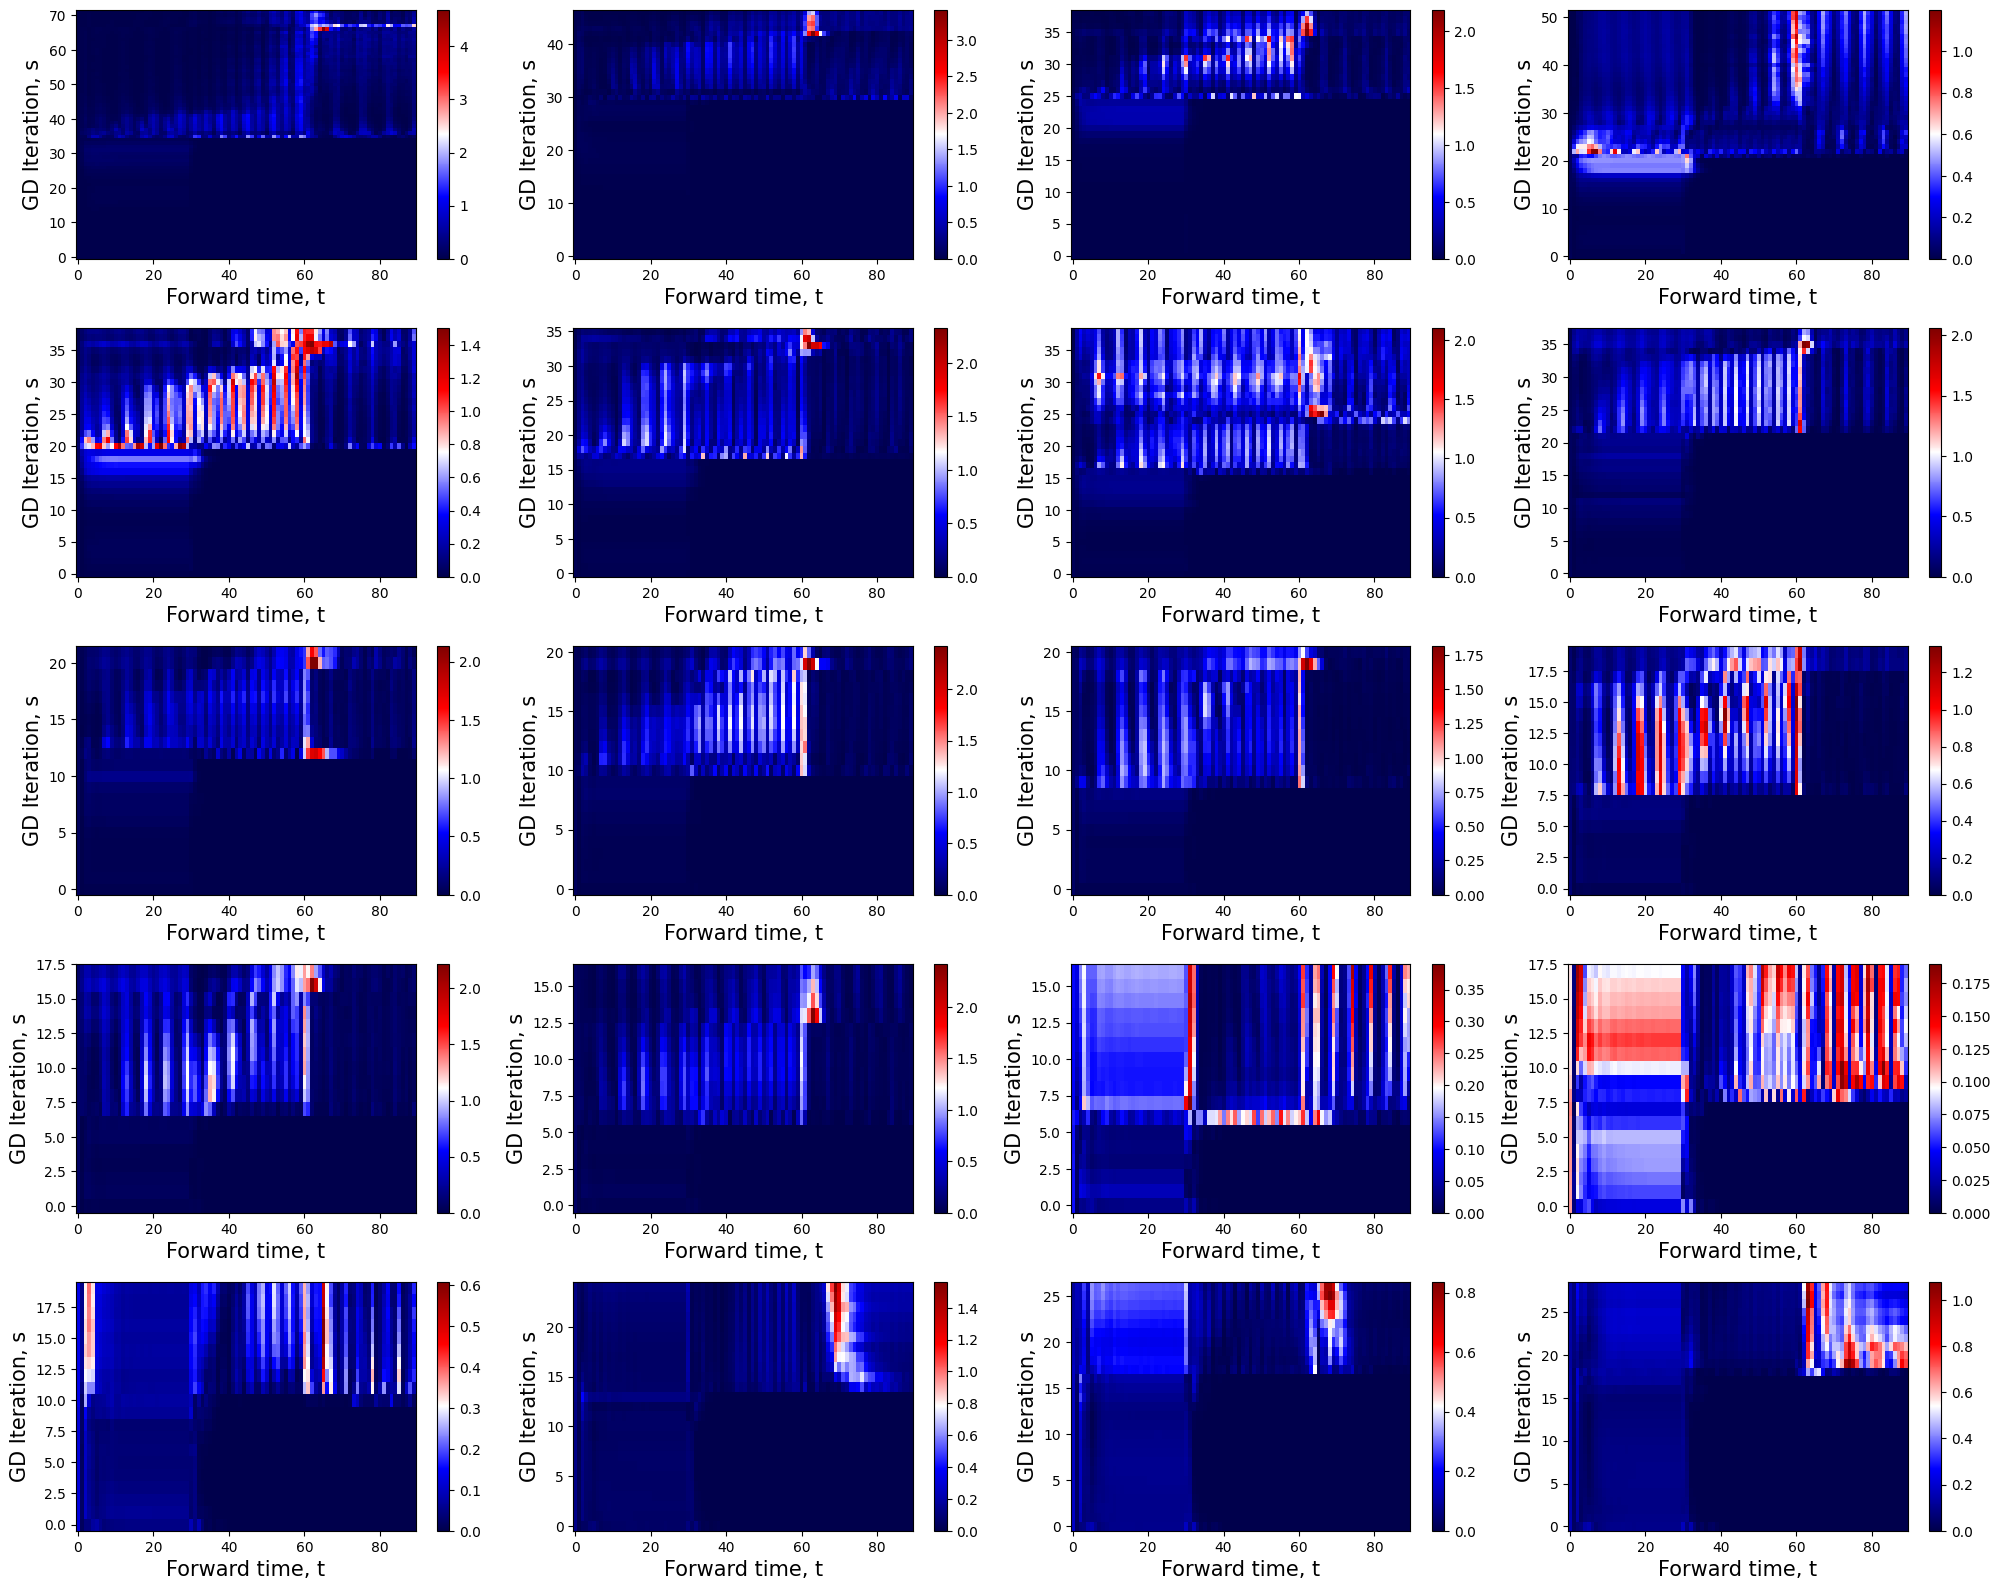

In [20]:
plt.figure(figsize = (20, 16))
for mf_idx in range(len(manifest)):
    sub = z_over_gd[split_inds[mf_idx]:split_inds[mf_idx+1]]
    means = np.mean(np.linalg.norm(sub, axis = -1), axis = 1)
    vars = np.var(np.linalg.norm(sub, axis = -1), axis = 1)

    plt.subplot(5, 4, mf_idx + 1)
    plt.imshow(vars, aspect = 'auto', cmap = 'seismic', origin = 'lower')
    plt.ylabel('GD Iteration, s', fontsize = 15)
    plt.xlabel('Forward time, t', fontsize = 15)
    plt.colorbar()

plt.tight_layout()
plt.show()

In [44]:
state_dicts = []
scales = np.linspace(0., 10., 1000)
for scale in scales:
    model = ModelRNNv2()
    with torch.no_grad():
        model.W.weight.data *= scale
        model.W_in.weight.data *= scale
        model.W_out.weight.data *= scale
    state_dicts.append(model.state_dict())
zs_manual = rerun_trials(memory_pro, state_dicts, noise = False, N = 100)

Re-evaluating on the Same Data.


 27%|██▋       | 268/1000 [00:03<00:09, 81.27it/s]


KeyboardInterrupt: 

In [12]:
single_checkpoints = load_checkpoints('init_bigger_cat_pro_sgd/')[0]
print(len(single_checkpoints))
single_checkpoints = single_checkpoints[:30]
X, Y, zs_single, adjs_single, losses_single = rerun_trials(d1fp2, single_checkpoints, compute_adj=True, noise = False, N = 300)

0
Re-evaluating on the Same Data.


0it [00:00, ?it/s]


ValueError: need at least one array to stack

/tmp/ipykernel_7707/3525433057.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  plt.plot(torch.load(load_checkpoints('d1fp2/')[0][-1])['losses'])
/tmp/ipykernel_7707/3525

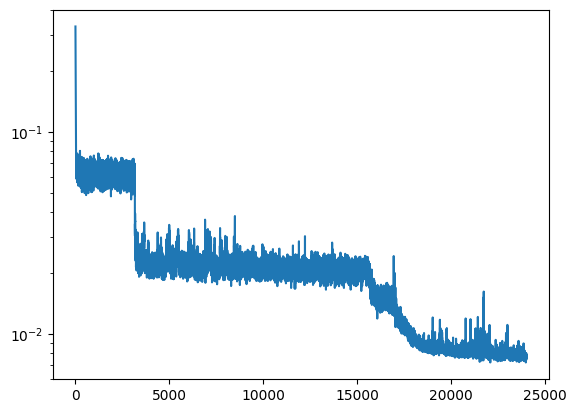

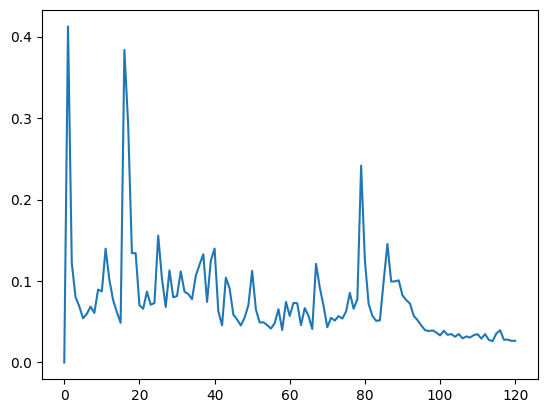

In [42]:
plt.plot(torch.load(load_checkpoints('d1fp2/')[0][-1])['losses'])
plt.yscale('log')

plt.figure()
W = torch.load(load_checkpoints('d1fp2/')[0][0])['model']['W.weight'].cpu().detach().numpy()
diffs = []
for ch in load_checkpoints('d1fp2/')[0]:
    W_next = torch.load(ch)['model']['W.weight'].cpu().detach().numpy()
    diffs.append(np.linalg.norm(W - W_next))
    W = W_next

plt.plot(diffs)

(25, 90, 3000)


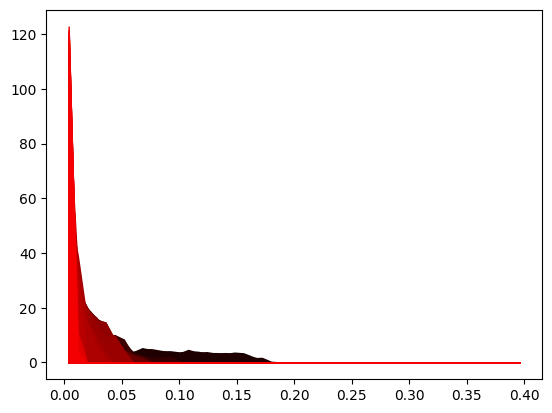

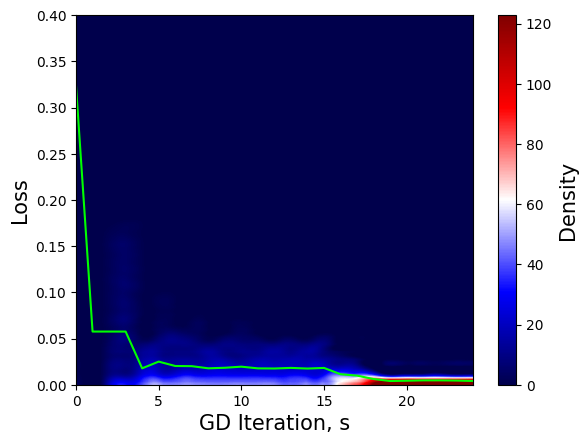

In [7]:
losses = losses_single.mean(1)
bins = 50
hists = np.zeros((losses.shape[0], bins))
edges = np.zeros_like(hists)
print(losses_single.shape)
for i in range(2,losses.shape[0]):
    hists[i], all_edge = np.histogram(losses[i], bins, density = True, range = (0, 0.4))
    edges[i] = (all_edge[1:] + all_edge[:-1]) / 2.
    smoothed = smooth(hists[i], 1)
    plt.fill_between(edges[i], 0 * hists[i], smoothed, color = [i / losses.shape[0], 0., 0.])
    # plt.plot(edges[i], smoothed, color = [i / losses.shape[0], 0., 0.])
plt.show()

# plt.figure(figsize=(12,12))
plt.imshow(hists.T, aspect='auto', origin='lower', extent = [0,losses.shape[0]-1,0,0.4], cmap='seismic', interpolation='sinc')
plt.plot(losses.mean(1), c = [0,1,0])
plt.xlabel('GD Iteration, s', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(0, 0.4)
cb = plt.colorbar()
cb.set_label('Density', fontsize=15)
plt.show()

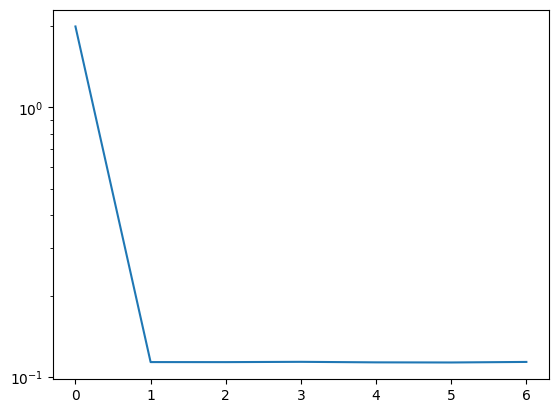

In [41]:
# Mean of distribution (MSE loss) should go down over training:
losses = losses_single.mean(1)
plt.plot(losses.mean(1))
plt.yscale('log')
plt.show()

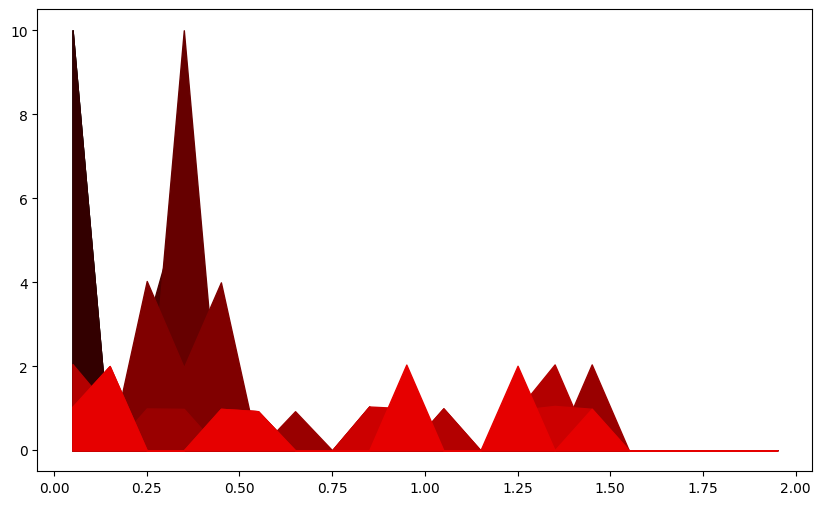

In [102]:
plt.figure(figsize=(10,6))
ts = list(range(50, 90, 4))
for idx, t in enumerate(ts):
    losses = losses_single[:, t]
    bins = 20
    hists = np.zeros((losses.shape[0], bins))
    edges = np.zeros_like(hists)
    # plt.subplot(3,4,idx+1)
    for i in range(losses.shape[0]-1, losses.shape[0]): #losses.shape[0]):
        hists[i], all_edge = np.histogram(losses[i], bins, density = True, range = (0, 2))
        edges[i] = (all_edge[1:] + all_edge[:-1]) / 2.
        smoothed = smooth(hists[i], 1)
        plt.fill_between(edges[i], 0 * hists[i], smoothed, color = [idx / len(ts), 0., 0.])
        # plt.plot(edges[i], smoothed, color = [i / losses.shape[0], 0., 0.])
plt.show()

501
Re-evaluating on the Same Data.


final_code/init_bigger_cat_pro_sgd/checkpoints/checkpoint_0.pt:   0%|          | 0/30 [00:00<?, ?it/s]

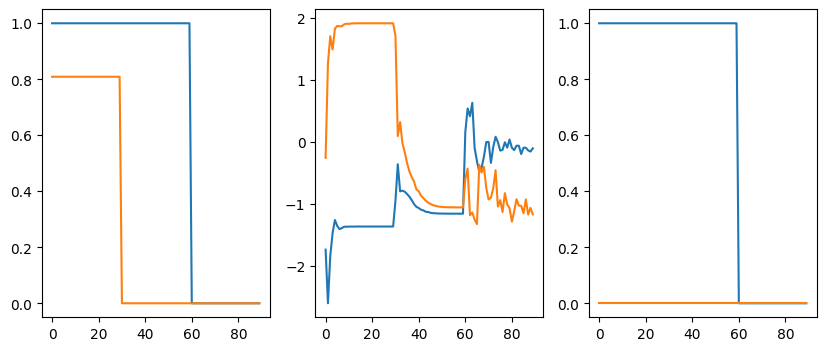

final_code/init_bigger_cat_pro_sgd/checkpoints/checkpoint_5800.pt:  97%|█████████▋| 29/30 [00:01<00:00, 24.50it/s]

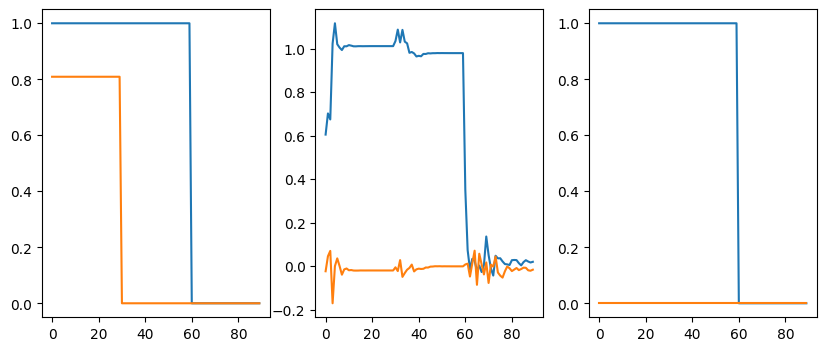

final_code/init_bigger_cat_pro_sgd/checkpoints/checkpoint_5800.pt: 100%|██████████| 30/30 [00:01<00:00, 20.35it/s]


In [8]:
single_checkpoints = load_checkpoints('final_code/init_bigger_cat_pro_sgd/')[0]
print(len(single_checkpoints))
single_checkpoints = single_checkpoints[:30]
X, Y, zs_single, losses_single = rerun_trials(category_pro, single_checkpoints, noise = False, N = 3000)

(35, 90, 3000)


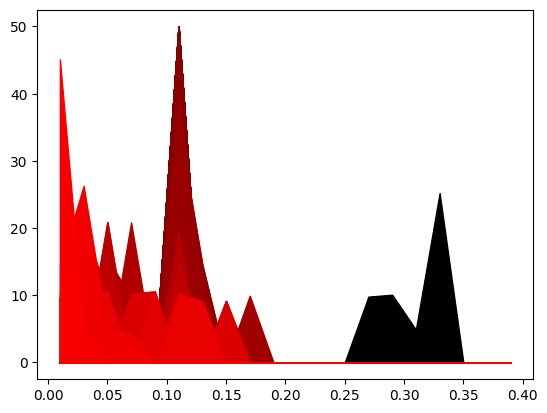

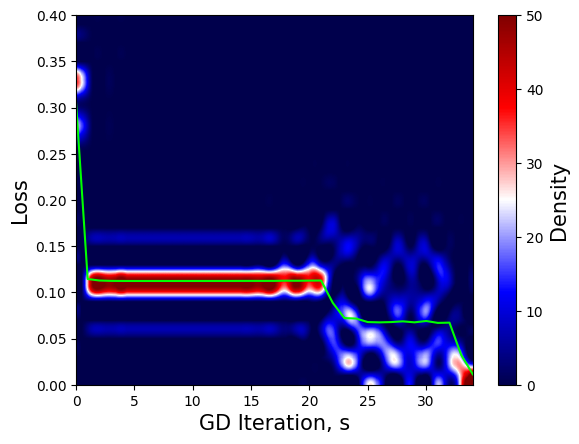

In [34]:
losses = losses_single.mean(1)
bins = 20
hists = np.zeros((losses.shape[0], bins))
edges = np.zeros_like(hists)
print(losses_single.shape)
for i in range(losses.shape[0]):
    hists[i], all_edge = np.histogram(losses[i], bins, density = True, range = (0, 0.4))
    edges[i] = (all_edge[1:] + all_edge[:-1]) / 2.
    smoothed = smooth(hists[i], 1)
    plt.fill_between(edges[i], 0 * hists[i], smoothed, color = [i / losses.shape[0], 0., 0.])
    # plt.plot(edges[i], smoothed, color = [i / losses.shape[0], 0., 0.])
plt.show()


plt.imshow(hists.T, aspect='auto', origin='lower', extent = [0,losses.shape[0]-1,0,0.4], cmap='seismic', interpolation='sinc')
plt.plot(losses.mean(1), c = [0,1,0])
plt.xlabel('GD Iteration, s', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(0, 0.4)
cb = plt.colorbar()
cb.set_label('Density', fontsize=15)
plt.show()

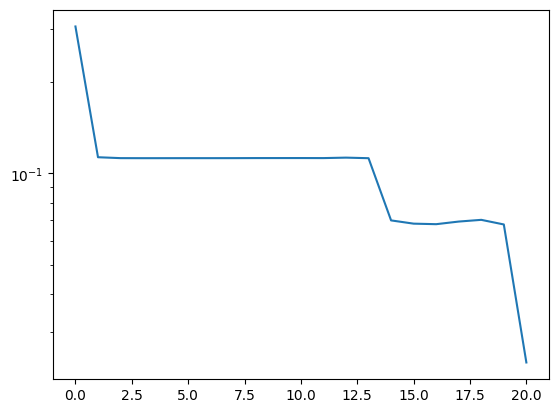

In [94]:
# Mean of distribution (MSE loss) should go down over training:
losses = losses_single.mean(1)
plt.plot(losses.mean(1))
plt.yscale('log')
plt.show()

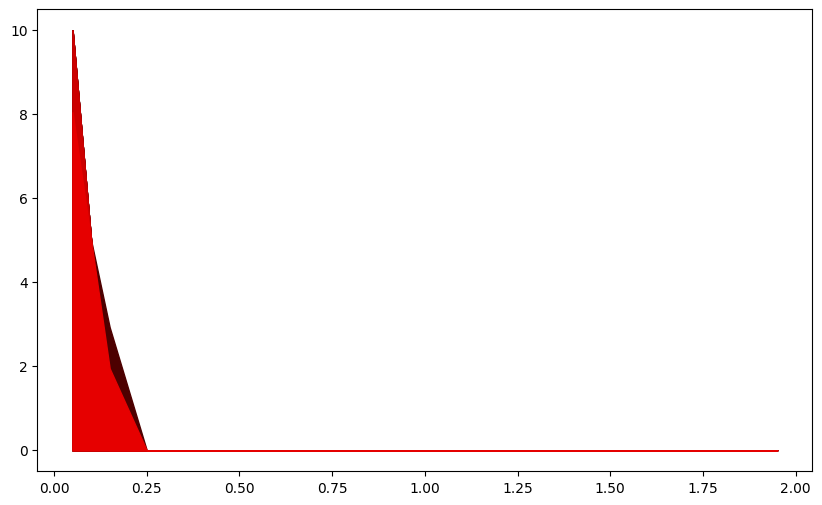

In [95]:
plt.figure(figsize=(10,6))
ts = list(range(50, 90, 4))
for idx, t in enumerate(ts):
    losses = losses_single[:, t]
    bins = 20
    hists = np.zeros((losses.shape[0], bins))
    edges = np.zeros_like(hists)
    # plt.subplot(3,4,idx+1)
    for i in range(losses.shape[0]-1, losses.shape[0]): #losses.shape[0]):
        hists[i], all_edge = np.histogram(losses[i], bins, density = True, range = (0, 2))
        edges[i] = (all_edge[1:] + all_edge[:-1]) / 2.
        smoothed = smooth(hists[i], 1)
        plt.fill_between(edges[i], 0 * hists[i], smoothed, color = [idx / len(ts), 0., 0.])
        # plt.plot(edges[i], smoothed, color = [i / losses.shape[0], 0., 0.])
plt.show()

In [9]:
def batched_cov_and_pcs(traj, traj2 = None, dim_thresh = 0.95, abs_thresh = 1e-6):
    # traj is shape [D, B, T, H]. D is trials, B is baches (what we mean over), T is time, H is hidden index.
    # If traj2 is not None, we take cross covariances, assuming traj2 has the same shape.
    centered = traj - traj.mean(1)[:, None]
    if traj2 is not None:
        centered2 = traj2 - traj2.mean(1)[:, None]
    
    covs = np.zeros((*traj.shape[:-3], traj.shape[-2], traj.shape[-1], traj.shape[-1])) # [D, T, H, H]
    for idx, zs in enumerate(traj):
        for tidx, z_t in enumerate(zs.transpose(1,2,0)): # Shape [H, B]
            if traj2 is None:
                cov = np.cov(z_t)
            else:
                cov = np.mean(centered[idx, :, tidx, :, None] * centered2[idx, :, tidx, None, :], 0) # [H, H]
            covs[idx, tidx] = cov


    evals, pcs = np.linalg.eigh(covs) # Use symmery. Get principle components.
    evals, pcs = evals[:, :, ::-1], pcs[:, :, :, ::-1] # Make descending order. Shapes [D, T, H], [D, T, H, H]
    total_variances = np.sum(evals, axis = -1) # [D, T]
    variance_ratios = np.cumsum(evals / total_variances[..., None], axis = -1)
    dimensions = np.zeros_like(total_variances)
    for i1 in range(variance_ratios.shape[0]):
        for i2 in range(variance_ratios.shape[1]):
            if total_variances[i1,i2] < abs_thresh: 
                continue
            dim_idx = np.argwhere(variance_ratios[i1, i2] > dim_thresh)[0,0]
            v0 = 0. if dim_idx == 0 else variance_ratios[i1, i2, dim_idx-1]
            v1 = variance_ratios[i1, i2, dim_idx]
            dimensions[i1, i2] = dim_idx + (dim_thresh - v0) / (v1 - v0) + 1

    dimensions[total_variances < abs_thresh] = 0 # If the total variance is super low, the covariance is a point, so it doesn't make sense to use variance ratios.
    return covs, evals, pcs, variance_ratios, dimensions

In [10]:
print(zs_single.shape, adjs_single.shape)

NameError: name 'adjs_single' is not defined

In [11]:
plt.plot(adjs_single.mean((1,2,3)))

NameError: name 'adjs_single' is not defined

True


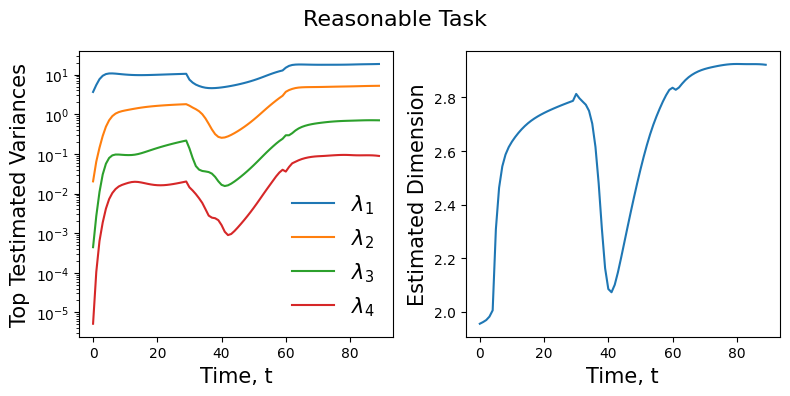

True


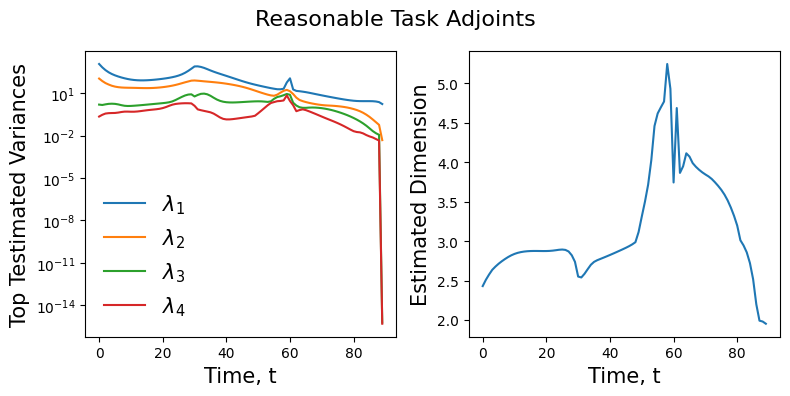

False


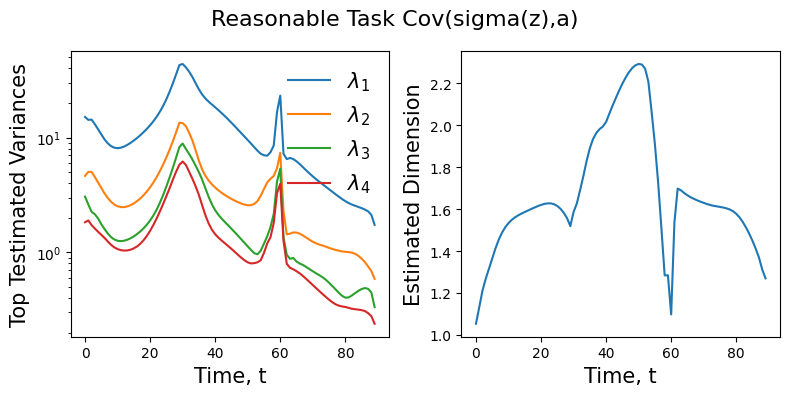

False


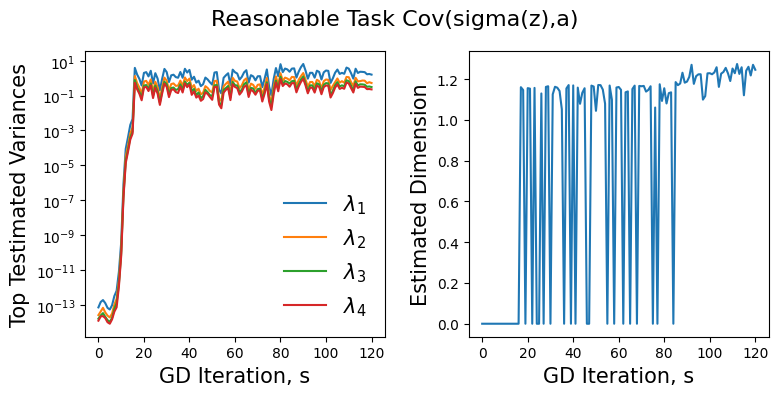

True


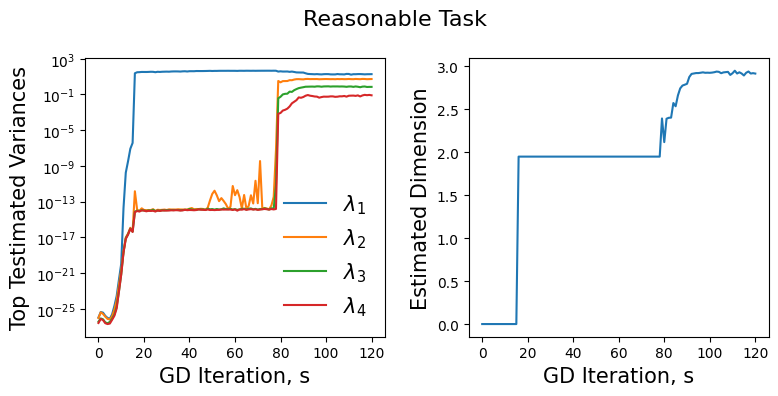

True


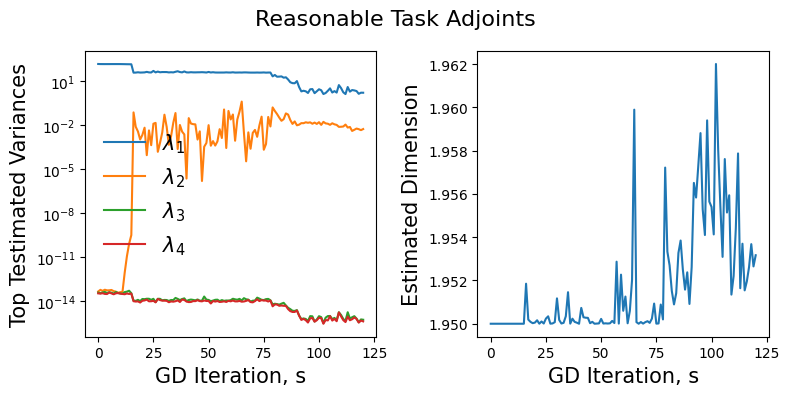

In [43]:
# final_t_gd_flow_1 = z_over_gd[split_inds[0]:split_inds[1], :, -1:, :].swapaxes(0, 2)
# final_t_gd_flow_2 = z_over_gd[split_inds[-2]:split_inds[-1], :, -1:, :].swapaxes(0, 2)
# manual_gd_scales = zs_manual[:, :, -1:, :].swapaxes(0, 2)

sig_z = np.tanh(zs_single)
plot_spec = [
    {'traj': sig_z[-2:-1], 'title': 'Reasonable Task', 'xlabel': 'Time, t', 'smoothing': 1},
    {'traj': 1e6*adjs_single[-2:-1], 'title': 'Reasonable Task Adjoints', 'xlabel': 'Time, t', 'smoothing': 1},
    {'traj': sig_z[-2:-1], 'traj2': 1e6*adjs_single[-2:-1], 'title': 'Reasonable Task Cov(sigma(z),a)', 'xlabel': 'Time, t', 'smoothing': 1},
    {'traj': sig_z[:, :, -1:, :].swapaxes(0,2), 'traj2': 1e6*adjs_single[:, :, -1:, :].swapaxes(0,2), 'title': 'Reasonable Task Cov(sigma(z),a)', 'xlabel': 'GD Iteration, s', 'smoothing': 1},
    {'traj': sig_z[:, :, -1:, :].swapaxes(0,2), 'title': 'Reasonable Task', 'xlabel': 'GD Iteration, s', 'smoothing': 1},
    {'traj': 1e6*adjs_single[:, :, -1:, :].swapaxes(0,2), 'title': 'Reasonable Task Adjoints', 'xlabel': 'GD Iteration, s', 'smoothing': 1},
    # {'traj': final_t_gd_flow_1, 'title': 'z(T) Over GD, Small Init', 'xlabel': 'GD Iteration, s', 'smoothing': 1},
    # {'traj': final_t_gd_flow_2, 'title': 'z(T) Over GD, Big Init', 'xlabel': 'GD Iteration, s', 'smoothing': 1},
    # {'traj': z_over_gd[:1], 'title': 'Small Init Dynamics Before Training', 'xlabel': 'Time, t', 'smoothing': 1},
    # {'traj': z_over_gd[-1:], 'title': 'Small Init Dynamics After Training', 'xlabel': 'Time, t', 'smoothing': 1},
    # {'traj': manual_gd_scales, 'title': 'Scale Sweep Before Training', 'xlabel': 'Scale', 'smoothing': 30, 'xmax': scales[-1]},
]

for spec in plot_spec:
    traj, title, xlabel, smoothing = spec['traj'], spec['title'], spec['xlabel'], spec['smoothing']
    traj2 = spec.get('traj2', None)
    print(traj2 is None)
    covs, evals, pcs, variance_ratios, dims = batched_cov_and_pcs(traj, traj2)

    plt.figure(figsize = (8, 4))
    plt.subplot(1,2,1)
    for ev_idx in range(4):
        plt.plot(evals[0, :, ev_idx], label  = f'$\lambda_{ev_idx+1}$')
    plt.ylabel('Top Testimated Variances', fontsize = 15)
    plt.yscale('log')
    plt.xlabel(xlabel, fontsize = 15)
    plt.legend(frameon=False, fontsize = 15)

    plt.subplot(1,2,2)
    plt.xlabel(xlabel, fontsize = 15) 
    plt.ylabel('Estimated Dimension', fontsize = 15)
    dim_smooth = smooth(dims[0], smoothing, mode = 'valid')
    plt.plot(dim_smooth)
    # if 'xmax' in spec:
    #   plt.xlim(0, spec['xmax'])
    plt.suptitle(title, fontsize = 16)
    plt.tight_layout()
    plt.show()

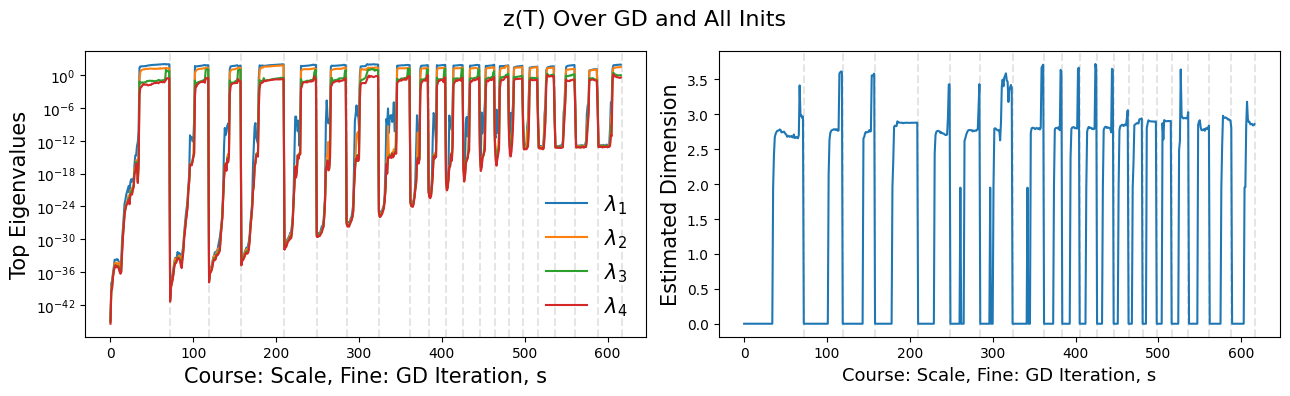

In [16]:
final_t_gd_flow_all = z_over_gd[:, :, -1:, :].swapaxes(0, 2)
covs, evals, pcs, variance_ratios, dims = batched_cov_and_pcs(final_t_gd_flow_all)

plt.figure(figsize = (13, 4))
plt.subplot(1,2,1)
for ev_idx in range(4):
    plt.plot(evals[0, :, ev_idx], label  = f'$\lambda_{ev_idx+1}$')
plt.ylabel('Top Eigenvalues', fontsize = 15)
plt.yscale('log')
plt.xlabel('Course: Scale, Fine: GD Iteration, s', fontsize = 15)
for split in split_inds[1:]:
    plt.axvline(split, c = 'black', linestyle = 'dashed', alpha = 0.1, zorder = -10)
plt.legend(frameon=False, fontsize = 15)

plt.subplot(1,2,2)
plt.xlabel('Course: Scale, Fine: GD Iteration, s', fontsize = 13)    
plt.ylabel('Estimated Dimension', fontsize = 15)
plt.plot(dims[0])
for split in split_inds[1:]:
    plt.axvline(split, c = 'black', linestyle = 'dashed', alpha = 0.1, zorder = -10)
plt.suptitle('z(T) Over GD and All Inits', fontsize = 16)
plt.tight_layout()
plt.show()

(2, 72, 20)


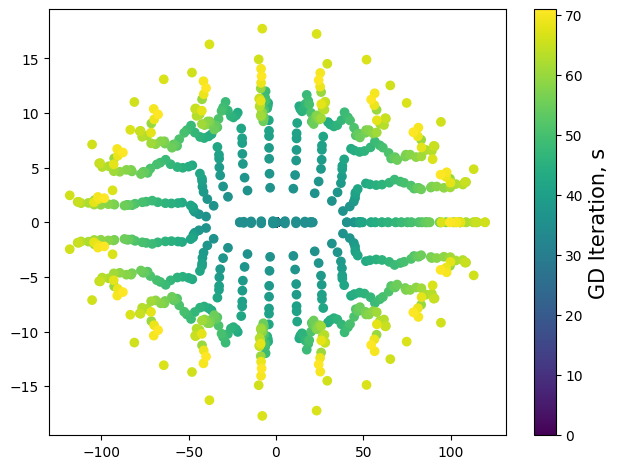

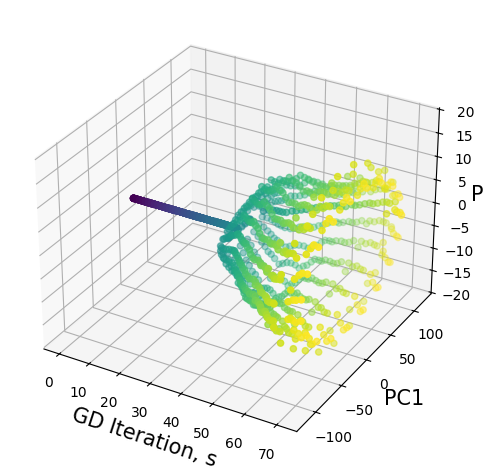

(2, 29, 20)


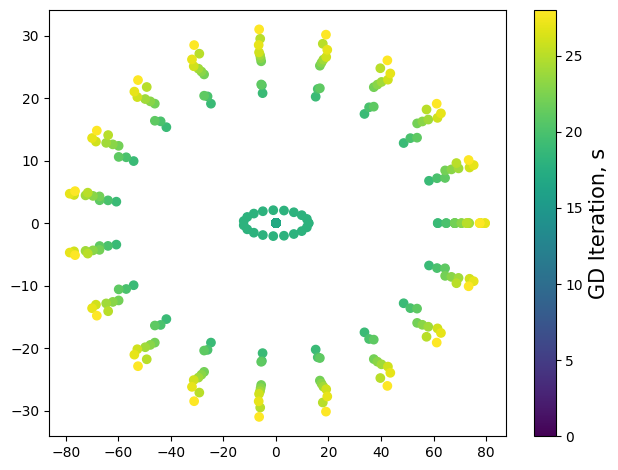

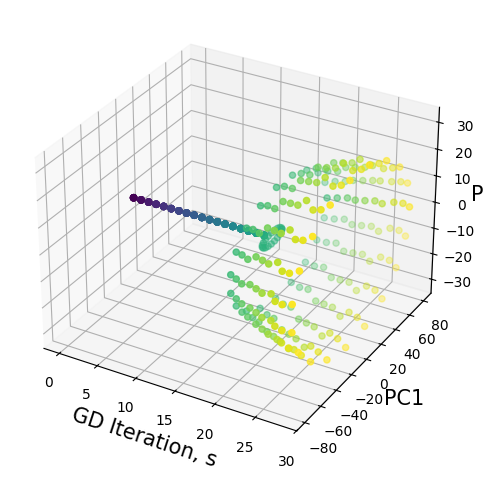

ValueError: axes don't match array

In [288]:
final_t_gd_flow_1 = z_over_gd[split_inds[0]:split_inds[1]][:, :, -1:, :].swapaxes(0, 2)
final_t_gd_flow_2 = z_over_gd[split_inds[-2]:split_inds[-1]][:, :, -1:, :].swapaxes(0, 2)

for traj, t_is_time in zip([final_t_gd_flow_1, final_t_gd_flow_2, z_trials[:1], z_trials[-1:]], [False, False, True]):
    covs, evals, pcs, _, _ = batched_cov_and_pcs(traj)
    covs, evals, pcs = covs[0], evals[0], pcs[0]

    circ_ts = np.linspace(0., 2 * np.pi, 20)
    circ = np.stack([evals[:, 0, None] * np.cos(circ_ts)[None, :], evals[:, 1, None] * np.sin(circ_ts)[None, :]])
    color = np.zeros_like(circ[0]) + np.arange(evals.shape[0])[:, None]
    plt.scatter(circ[0], circ[1], c = color)
    cbar = plt.colorbar()
    if t_is_time:
        cbar.ax.set_ylabel('Time, t', fontsize = 15)
    else:
        cbar.ax.set_ylabel('GD Iteration, s', fontsize = 15)
    plt.tight_layout()

    plt.figure()
    ax = plt.axes(projection='3d')
    print(circ.shape)
    X = np.zeros_like(circ[0]) + np.arange(evals.shape[0])[:, None]
    ax.scatter(X, circ[0], circ[1], c = color)
    if t_is_time:
        ax.set_xlabel('Time, t', fontsize = 15)
    else:
        ax.set_xlabel('GD Iteration, s', fontsize = 15)
    ax.set_ylabel('PC1', fontsize = 15)
    ax.set_zlabel('PC2', fontsize = 15)
    plt.tight_layout()
    plt.show()

Re-evaluating on the Same Data.


final_code/sweep/grid_0/best.pt: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


(101, 90, 3, 3)


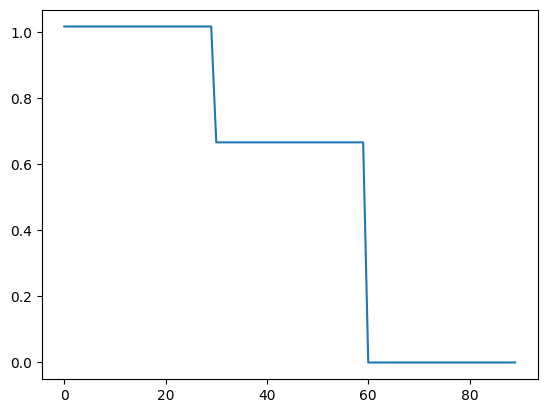

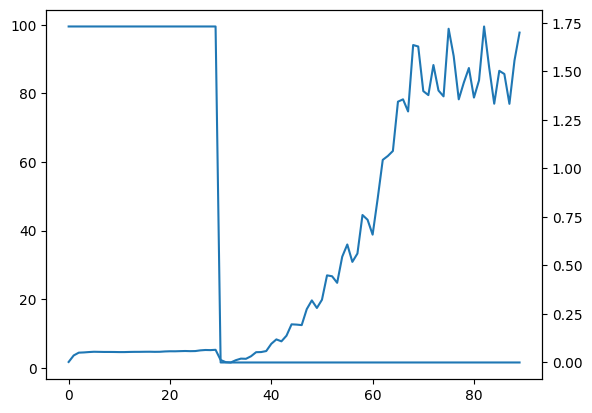

In [301]:
# Estimating variance evolution. 
ch = 'final_code/' + manifest[0]['prefix'] + 'best.pt'
model_dict = torch.load(ch, map_location='cpu', weights_only=True)['model']
W, W_in = model_dict['W.weight'], model_dict['W_in.weight']
W, W_in = W.detach().numpy(), W_in.detach().numpy()
inps, targs, zs, adjs, losses = rerun_trials(task, [ch], N = 101, compute_adj = True) # [B, T, n_in], [B, T, n_out], ...
zs, adjs, losses = zs[0], adjs[0], losses[0].T # [B, T, H], [B, T, H], [B, T]
inps, targs = inps.numpy(), targs.numpy()

emp_cov = batched_cov_and_pcs(zs[None])[0][0] # [T, H, H]: covariance matrix over time.
def update_cov(z, x):
    # cov_Z shape [H, H], z shape [B, H], x shape [B, n_in]
    B = z.shape[0]
    J_avg = np.diag(np.mean(1. / np.cosh(z)**2, axis = 0)) @ W # [H, H]
    J_x = W_in

    z_centered = z - np.mean(z, axis = 0)[None]
    x_centered = x - np.mean(x, axis = 0)[None]

    cov_x = (x_centered.T @ x_centered) / (B - 1) # Shape (n_in, n_in)
    cov_z = (z_centered.T @ z_centered) / (B - 1) # Shape (n, n)

    cov_xz = (x_centered.T @ z_centered) / (B - 1)  # Shape (n_in, n)
    return J_avg @ cov_z @ J_avg.T + J_x @ cov_x @ J_x.T + 2 * (J_x @ cov_xz @ J_avg.T) 

z = np.zeros((zs.shape[0], zs.shape[2]))
cov_guesses = []
for t in range(zs.shape[1]):
    cov_guesses.append(update_cov(z, inps[:, t]))
cov_guesses = np.stack(cov_guesses) # [T, H, H]

center_X = inps - inps.mean(-1)[...,None]
cov_X = (center_X[..., :, None] * center_X[..., None, :])
print(cov_X.shape)
plt.plot(np.linalg.norm(np.mean(cov_X, 0).reshape((zs.shape[1], -1)), axis = 1))
plt.show()

plt.plot(np.linalg.norm(emp_cov.reshape((zs.shape[1], -1)), axis = 1))
plt.gca().twinx()
plt.plot(np.linalg.norm(cov_guesses.reshape((zs.shape[1], -1)), axis = 1))
plt.show()

In [ ]:
Ws = 

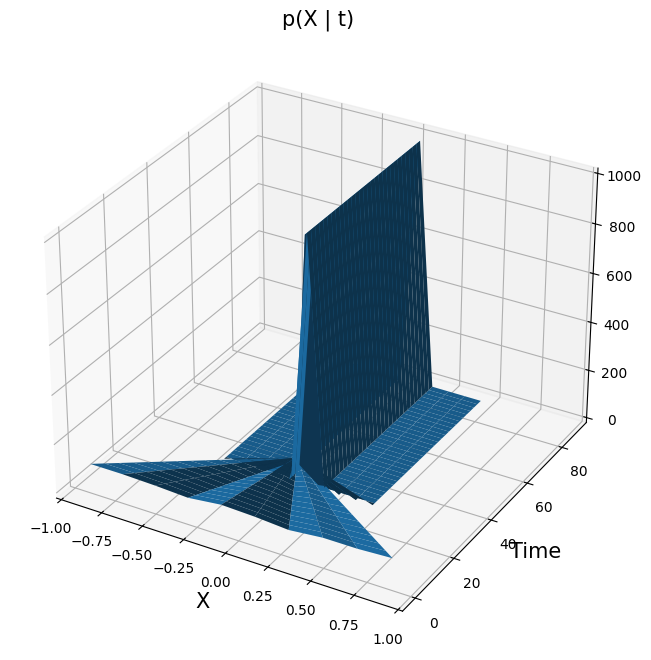

In [306]:
import d1fp2_correlated_x as task
cfg = task.DEFAULT_CFG
cfg['n_samples'] = 1000
X, Y = task.generate(noise=False, cfg = cfg)
X = X.numpy()
nbin = 10

X_hist = np.zeros((X.shape[1], nbin))
X_edges = np.zeros((X.shape[1], nbin))
for i in range(X.shape[1]):
    X_hist[i], edges = np.histogram(X[:, i, 1], bins = nbin)
    X_edges[i] = (edges[1:] + edges[:-1]) / 2

y_coord = np.zeros_like(X_edges)
y_coord += np.arange(X_edges.shape[0])[:, None]

plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(X_edges[:89], y_coord[:89], X_hist[:89])
ax.set_xlabel('X', fontsize = 15)
ax.set_ylabel('Time', fontsize = 15)
plt.title('p(X | t)', fontsize = 15)
# for i in range(X_edges.shape[0]):
#     plt.plot(X_edges[i], X_hist[i])

plt.show()

TODO: Analyze jacobian eigenvalues at the collapsed FP early in training

Push scale to find other regimes

Phase space of averaged and outlier activity (fraction of networks that trained)

W(s) eigenvalues over training s

Todo: framing and intro and main theorem writeup
